# Ecological Index - SIC validation plots
- Plot CESM data vs. observations
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- July 2025

In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
#import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
import utils
import pandas as pd
import geopandas as gpd
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -50

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

## Load CESM2-LE SIC data

In [6]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/environment/'
ds_ice = xr.open_dataset(path_in+'CESM2-LE-SIC_season.nc')
ds_ice

<xarray.Dataset>
Dimensions:    (member_id: 50, time: 150, nlat: 55, nlon: 320)
Coordinates:
  * member_id  (member_id) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
  * time       (time) int64 1950 1951 1952 1953 1954 ... 2096 2097 2098 2099
  * nlat       (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 46 47 48 49 50 51 52 53 54
  * nlon       (nlon) int64 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
Data variables:
    SIC_JFM    (time, member_id, nlat, nlon) float64 ...
    SIC_AMJ    (time, member_id, nlat, nlon) float64 ...
    SIC_JAS    (time, member_id, nlat, nlon) float64 ...
    SIC_OND    (time, member_id, nlat, nlon) float64 ...
Attributes:
    author:          Alice DuVivier
    date_processed:  2025-08-06
    contents:        Seasonal sea ice fraction in the Southern Ocean from 195...

In [7]:
# TRIM time to NOAA/NSIDC CDR record, 1979 to 2020
ds_ice = ds_ice.where(ds_ice.time >= 1979, drop=True)
ds_ice = ds_ice.where(ds_ice.time <= 2020, drop=True)

ds_ice_cesm2le = ds_ice
ds_ice_cesm2le.time

<xarray.DataArray 'time' (time: 42)>
array([1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020])
Coordinates:
  * time     (time) int64 1979 1980 1981 1982 1983 ... 2016 2017 2018 2019 2020

## Load CESM2 Hindcast SIC data

In [8]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/environment/'
ds_ice = xr.open_dataset(path_in+'CESM2-JRA55-hindcast-SIC_season.nc')
ds_ice

<xarray.Dataset>
Dimensions:  (time: 63, nlat: 55, nlon: 320)
Coordinates:
  * time     (time) int64 1958 1959 1960 1961 1962 ... 2016 2017 2018 2019 2020
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52 53 54
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
Data variables:
    SIC_JFM  (time, nlat, nlon) float64 ...
    SIC_AMJ  (time, nlat, nlon) float64 ...
    SIC_JAS  (time, nlat, nlon) float64 ...
    SIC_OND  (time, nlat, nlon) float64 ...
Attributes:
    author:          Alice DuVivier
    date_processed:  2025-08-06
    contents:        Seasonal sea ice fraction in the Southern Ocean from 195...

In [9]:
# TRIM time to NOAA/NSIDC CDR record, 1979 to 2020
ds_ice = ds_ice.where(ds_ice.time >= 1979, drop=True)
ds_ice = ds_ice.where(ds_ice.time <= 2020, drop=True)

ds_ice_hindcast = ds_ice
ds_ice_hindcast.time

<xarray.DataArray 'time' (time: 42)>
array([1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020])
Coordinates:
  * time     (time) int64 1979 1980 1981 1982 1983 ... 2016 2017 2018 2019 2020

## Load OBS SIC data

In [10]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/validation_data/'

In [11]:
ds_sat_ice = xr.open_dataset(path_in+'ssmi_cdr_monthly_data_gx1v5_197901-202012.nc')
ds_sat_ice['time'] = pd.date_range(start="1979-01-01", end="2021-01-01",freq="M")
ds_sat_ice = ds_sat_ice.isel(jdim=slice(0,55))
ds_sat_ice = ds_sat_ice.rename({'jdim' : 'nlat', 'idim' : 'nlon'})

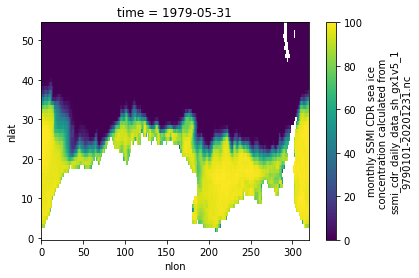

In [12]:
ds_sat_ice.CDR_seaice.isel(time=4).plot()

### Compute seasonal averages

In [13]:
#starting with Jan, list of days in each month
days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

#### Winter - JAS

In [14]:
#files
#data goes from Sept 1997 to Feb 2022

var = 'CDR_seaice'
ylen = 55
xlen = 320

Jul_Sep_mean = np.zeros([42,ylen,xlen])

year = 0 

## Make JAS average
for ts in np.arange(0,504,12):

    #print(files[ts]) these are the octobers
    print(ts)

    #july first
    summing = ds_sat_ice[var].isel(time=ts+6) * days_per_month[6]
    tot_days = days_per_month[9]

    #august
    summing = summing + ds_sat_ice[var].isel(time=ts+7) * days_per_month[7]
    tot_days = tot_days + days_per_month[10]

    #september
    summing = summing + ds_sat_ice[var].isel(time=ts+8) * days_per_month[8]
    tot_days = tot_days + days_per_month[11]    

    Jul_Sep_mean[year,:,:] = (summing/tot_days).compute()

    year = year + 1
    
sat_ice_jas = xr.DataArray(Jul_Sep_mean,dims=('time','lat','lon'))

sat_ice_jas['time'] = np.arange(1979,2021,1)

0
12
24
36
48
60
72
84
96
108
120
132
144
156
168
180
192
204
216
228
240
252
264
276
288
300
312
324
336
348
360
372
384
396
408
420
432
444
456
468
480
492


#### Summer - JFM

In [15]:
#files
#data goes from Sept 1997 to Feb 2022

var = 'CDR_seaice'
ylen = 55
xlen = 320

Jan_Mar_mean = np.zeros([42,ylen,xlen])

year = 0 

## Make JAS average
for ts in np.arange(0,504,12):

    #print(files[ts]) these are the octobers
    print(ts)

    #january first
    summing = ds_sat_ice[var].isel(time=ts+0) * days_per_month[0]
    tot_days = days_per_month[0]

    #february
    summing = summing + ds_sat_ice[var].isel(time=ts+1) * days_per_month[1]
    tot_days = tot_days + days_per_month[1]

    #march
    summing = summing + ds_sat_ice[var].isel(time=ts+2) * days_per_month[2]
    tot_days = tot_days + days_per_month[2]    

    Jan_Mar_mean[year,:,:] = (summing/tot_days).compute()

    year = year + 1
    
sat_ice_jfm = xr.DataArray(Jan_Mar_mean,dims=('time','lat','lon'))

sat_ice_jfm['time'] = np.arange(1979,2021,1)

0
12
24
36
48
60
72
84
96
108
120
132
144
156
168
180
192
204
216
228
240
252
264
276
288
300
312
324
336
348
360
372
384
396
408
420
432
444
456
468
480
492


# Compute means and standard deviation and Coefficient of variation (CV)

## OBS

In [16]:
sat_ice_jas_mean = sat_ice_jas.mean(dim='time')
sat_ice_jfm_mean = sat_ice_jfm.mean(dim='time')

In [17]:
sat_ice_jas_std = sat_ice_jas.std(dim='time')
sat_ice_jfm_std = sat_ice_jfm.std(dim='time')

In [18]:
sat_ice_jas_cv = sat_ice_jas_std/sat_ice_jas_mean
sat_ice_jfm_cv = sat_ice_jfm_std/sat_ice_jfm_mean

## CESM2-LE

In [19]:
cesm2le_ice_jas_mean = ds_ice_cesm2le.SIC_JAS.mean(dim=('time','member_id'))
cesm2le_ice_jfm_mean = ds_ice_cesm2le.SIC_JFM.mean(dim=('time','member_id'))

In [20]:
cesm2le_ice_jas_std = ds_ice_cesm2le.SIC_JAS.std(dim=('time','member_id'))
cesm2le_ice_jfm_std = ds_ice_cesm2le.SIC_JFM.std(dim=('time','member_id'))

In [21]:
cesm2le_ice_jas_cv = cesm2le_ice_jas_std/cesm2le_ice_jas_mean.compute()
cesm2le_ice_jfm_cv = cesm2le_ice_jfm_std/cesm2le_ice_jfm_mean.compute()

## CESM2 Hindcast

In [22]:
hindcast_ice_jas_mean = ds_ice_hindcast.SIC_JAS.mean(dim=('time'))
hindcast_ice_jfm_mean = ds_ice_hindcast.SIC_JFM.mean(dim=('time'))

In [23]:
hindcast_ice_jas_std = ds_ice_hindcast.SIC_JAS.std(dim=('time'))
hindcast_ice_jfm_std = ds_ice_hindcast.SIC_JFM.std(dim=('time'))

In [24]:
hindcast_ice_jas_cv = hindcast_ice_jas_std/hindcast_ice_jas_mean.compute()
hindcast_ice_jfm_cv = hindcast_ice_jfm_std/hindcast_ice_jfm_mean.compute()

## Get shapefile with geography

In [25]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [26]:
# Read in Antarctic Geography Shapefiles
file_in = 'USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'

shdf_ant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ant = shdf_ant.to_crs(ccrs.SouthPolarStereo())

## Make SIC model validation plots

In [28]:
#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [29]:
lats = ds_grid.TLAT
lons = ds_grid.TLONG

In [34]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_6/'

### Plot Averages by season

In [35]:
# set plotting limits
vmin_in = 0
vmax_in = 100
cmap = 'YlGnBu_r'

In [36]:
# set output file name
fout = 'SFigure_SIC_validation_JAS_avg'

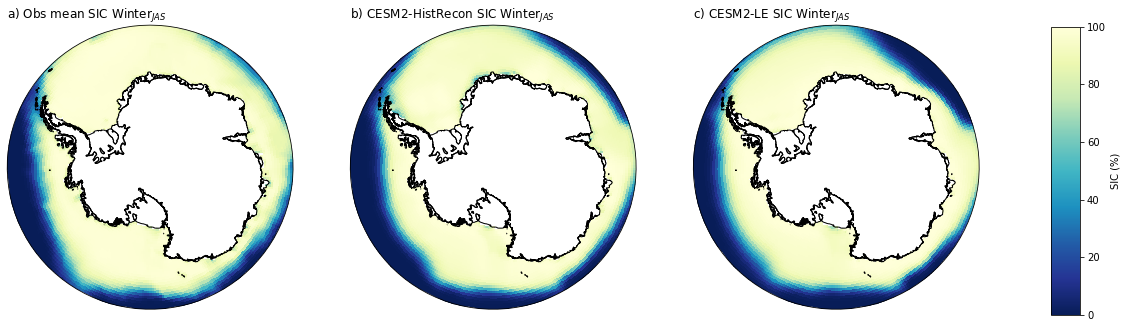

In [37]:
# Plot
# create figure
fig = plt.figure(figsize=(20,20))

# plot the region as subplots - note it's nrow x ncol x index (starting upper left)

### Plot Obs ###
ax = fig.add_subplot(1,3,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('a) Obs mean SIC Winter$_{JAS}$', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, sat_ice_jas_mean)
this=ax.pcolormesh(lon, lat, 
                field,transform=ccrs.PlateCarree(),
               vmin=vmin_in,vmax=vmax_in, cmap=cmap)
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot CESM2 hindcast ###
ax = fig.add_subplot(1,3,2, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('b) CESM2-HistRecon SIC Winter$_{JAS}$', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, hindcast_ice_jas_mean*100.0)
this=ax.pcolormesh(lon, lat, 
                field,transform=ccrs.PlateCarree(),
               vmin=vmin_in,vmax=vmax_in, cmap=cmap)
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot CESM2-LE ###
ax = fig.add_subplot(1,3,3, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('c) CESM2-LE SIC Winter$_{JAS}$', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, cesm2le_ice_jas_mean*100.0)
this=ax.pcolormesh(lon, lat, 
                field,transform=ccrs.PlateCarree(),
               vmin=vmin_in,vmax=vmax_in, cmap=cmap)
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Add a common colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.4, 0.02, 0.2])
cbar1 = fig.colorbar(this, cax=cbar_ax,label='SIC (%)')

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

In [38]:
# set output file name
fout = 'SFigure_SIC_validation_JFM_avg'

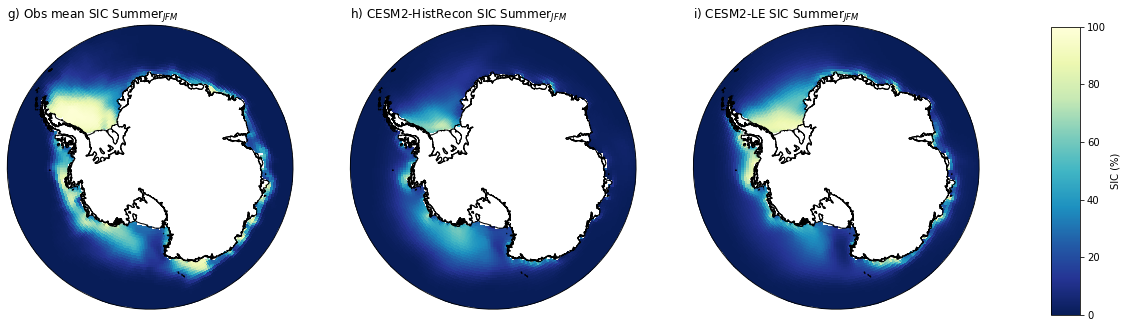

In [39]:
# Plot
# create figure
fig = plt.figure(figsize=(20,20))

# plot the region as subplots - note it's nrow x ncol x index (starting upper left)

### Plot Obs ###
ax = fig.add_subplot(1,3,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('g) Obs mean SIC Summer$_{JFM}$', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, sat_ice_jfm_mean)
this=ax.pcolormesh(lon, lat, 
                field,transform=ccrs.PlateCarree(),
               vmin=vmin_in,vmax=vmax_in, cmap=cmap)
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot CESM2 hindcast ###
ax = fig.add_subplot(1,3,2, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('h) CESM2-HistRecon SIC Summer$_{JFM}$', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, hindcast_ice_jfm_mean*100.0)
this=ax.pcolormesh(lon, lat, 
                field,transform=ccrs.PlateCarree(),
               vmin=vmin_in,vmax=vmax_in, cmap=cmap)
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot CESM2-LE ###
ax = fig.add_subplot(1,3,3, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('i) CESM2-LE SIC Summer$_{JFM}$', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, cesm2le_ice_jfm_mean*100.0)
this=ax.pcolormesh(lon, lat, 
                field,transform=ccrs.PlateCarree(),
               vmin=vmin_in,vmax=vmax_in, cmap=cmap)
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Add a common colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.4, 0.02, 0.2])
cbar1 = fig.colorbar(this, cax=cbar_ax,label='SIC (%)')

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

### Plot Standard Deviations by season

In [40]:
# set plotting limits
vmin_in = 0
vmax_in = 30
cmap = 'YlGnBu_r'

In [41]:
# set output file name
fout = 'SFigure_SIC_validation_JAS_std'

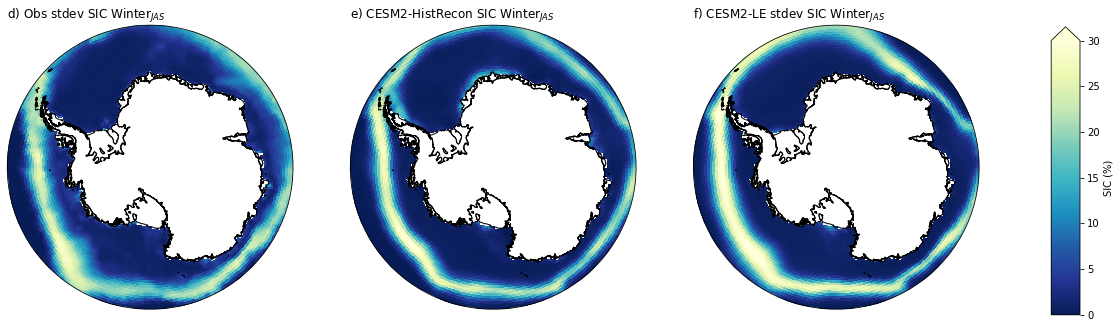

In [42]:
# Plot
# create figure
fig = plt.figure(figsize=(20,20))

# plot the region as subplots - note it's nrow x ncol x index (starting upper left)

### Plot Obs ###
ax = fig.add_subplot(1,3,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('d) Obs stdev SIC Winter$_{JAS}$', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, sat_ice_jas_std)
this=ax.pcolormesh(lon, lat, 
                field,transform=ccrs.PlateCarree(),
               vmin=vmin_in,vmax=vmax_in, cmap=cmap)
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot CESM2 hindcast ###
ax = fig.add_subplot(1,3,2, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('e) CESM2-HistRecon SIC Winter$_{JAS}$', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, hindcast_ice_jas_std*100.0)
this=ax.pcolormesh(lon, lat, 
                field,transform=ccrs.PlateCarree(),
               vmin=vmin_in,vmax=vmax_in, cmap=cmap)
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot CESM2-LE ###
ax = fig.add_subplot(1,3,3, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('f) CESM2-LE stdev SIC Winter$_{JAS}$', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, cesm2le_ice_jas_std*100.0)
this=ax.pcolormesh(lon, lat, 
                field,transform=ccrs.PlateCarree(),
               vmin=vmin_in,vmax=vmax_in, cmap=cmap)
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Add a common colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.4, 0.02, 0.2])
cbar1 = fig.colorbar(this, cax=cbar_ax,extend='max',label='SIC (%)')

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

In [43]:
# set output file name
fout = 'SFigure_SIC_validation_JFM_std'

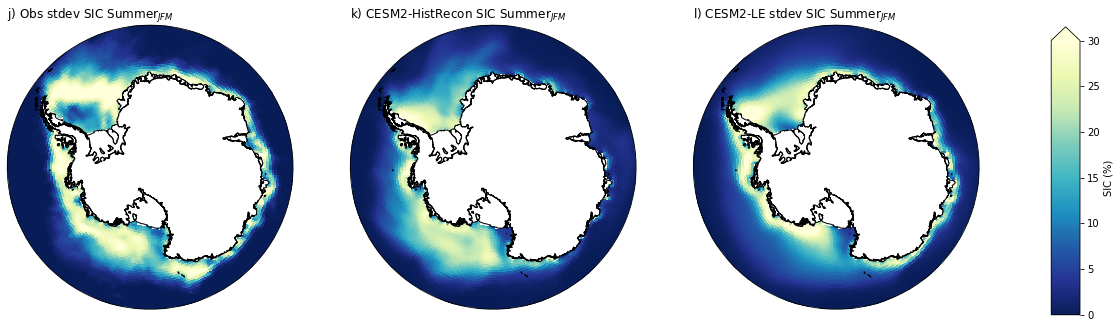

In [44]:
# Plot
# create figure
fig = plt.figure(figsize=(20,20))

# plot the region as subplots - note it's nrow x ncol x index (starting upper left)

### Plot Obs ###
ax = fig.add_subplot(1,3,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('j) Obs stdev SIC Summer$_{JFM}$', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, sat_ice_jfm_std)
this=ax.pcolormesh(lon, lat, 
                field,transform=ccrs.PlateCarree(),
               vmin=vmin_in,vmax=vmax_in, cmap=cmap)
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot CESM2 hindcast ###
ax = fig.add_subplot(1,3,2, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('k) CESM2-HistRecon SIC Summer$_{JFM}$', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, hindcast_ice_jfm_std*100.0)
this=ax.pcolormesh(lon, lat, 
                field,transform=ccrs.PlateCarree(),
               vmin=vmin_in,vmax=vmax_in, cmap=cmap)
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot CESM2-LE ###
ax = fig.add_subplot(1,3,3, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('l) CESM2-LE stdev SIC Summer$_{JFM}$', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, cesm2le_ice_jfm_std*100.0)
this=ax.pcolormesh(lon, lat, 
                field,transform=ccrs.PlateCarree(),
               vmin=vmin_in,vmax=vmax_in, cmap=cmap)
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Add a common colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.4, 0.02, 0.2])
cbar1 = fig.colorbar(this, cax=cbar_ax,extend='max',label='SIC (%)')

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)